## Business Case

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 
%load_ext memory_profiler
from sklearn.metrics import accuracy_score
from scipy.special import expit
import time
import math
from memory_profiler import memory_usage

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression as SKLogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

target_classifier = 'Shopping centres'
df = pd.read_csv('responses.csv', sep=",")


The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


## Define and Prepare Class Variables

In [45]:
# remove rows whose target classfier value is NaN
df_cleaned_classifier = df[np.isfinite(df[target_classifier])]
# change NaN number values to the mean
df_imputed = df_cleaned_classifier.fillna(df.mean())
# get categorical features
object_features = list(df_cleaned_classifier.select_dtypes(include=['object']).columns)
# one hot encode categorical features
one_hot_df = pd.concat([pd.get_dummies(df_imputed[col],prefix=col) for col in object_features], axis=1)
# drop object features from imputed dataframe
df_imputed_dropped = df_imputed.drop(object_features, 1)
frames = [df_imputed_dropped, one_hot_df]
# concatenate both frames by columns
df_fixed = pd.concat(frames, axis=1)

## Divide Data into Training and Testing

In [46]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if target_classifier in df_fixed:
    y = df_fixed[target_classifier].values # get the labels we want
    del df_fixed[target_classifier] # get rid of the class label
    X = df_fixed.values # use everything else to predict!

num_cv_iterations = 1
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,test_size = 0.2)

print(cv_object)

ShuffleSplit(n_splits=1, random_state=None, test_size=0.2, train_size=None)


## Creating Classes

In [47]:
%%time
# from last time, our logistic regression algorithm is given by (including everything we previously had):
class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001,reg=0):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.iterations = 0
        self.reg = reg
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        if(self.reg == 0):
            gradient[1:] += 2 * self.w_[1:] * self.C
        elif(self.reg == 1):
            gradient[1:] += np.sign(self.w_[1:]) * self.C
        else:
            gradient[1:] += 2 * self.w_[1:] * self.C
            gradient[1:] += np.sign(self.w_[1:]) * self.C
        #gradient[1:] += 2 * self.w_[1:] * self.C
        
        return gradient
    def _get_l1_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += np.sign(self.w_[1:]) * self.C
        return gradient
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 

# blr = BinaryLogisticRegression(eta=0.1,iterations=500,C=0.001)

# blr.fit(X,y)
# print(blr)

# yhat = blr.predict(X)
# print('Accuracy of: ',accuracy_score(y,yhat+1))

CPU times: user 35 µs, sys: 3 µs, total: 38 µs
Wall time: 43.2 µs


In [48]:
%%time
# and we can update this to use a line search along the gradient like this:
from scipy.optimize import minimize_scalar
from scipy.optimize import OptimizeResult

import copy
class LineSearchLogisticRegression(BinaryLogisticRegression):
    
    # define custom line search for problem
    @staticmethod
    def line_search_function(eta,X,y,w,grad,C):
        wnew = w + grad*eta
        yhat = expit(X @ wnew)>0.5
        return np.sum((y-yhat)**2) + C*np.sum(wnew**2)
     
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            
            # do line search in gradient direction, using scipy function
            opts = {'maxiter':self.iters/20} # unclear exactly what this should be
            res = minimize_scalar(self.line_search_function, # objective function to optimize
                                  bounds=(self.eta/1000,self.eta*10), #bounds to optimize
                                  args=(Xb,y,self.w_,gradient,self.C), # additional argument for objective function
                                  method='bounded', # bounded optimization for speed
                                  options=opts) # set max iterations
            eta = res.x # get optimal learning rate
            self.w_ += gradient*eta # set new function values
                
      

CPU times: user 68 µs, sys: 0 ns, total: 68 µs
Wall time: 72 µs


In [49]:
%%time
class StochasticLogisticRegression(BinaryLogisticRegression):
    # stochastic gradient calculation 
    def _get_gradient(self,X,y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        if(self.reg == 0):
            gradient[1:] += 2 * self.w_[1:] * self.C
        elif(self.reg == 1):
            gradient[1:] += np.sign(self.w_[1:]) * self.C
        else:
            gradient[1:] += 2 * self.w_[1:] * self.C
            gradient[1:] += np.sign(self.w_[1:]) * self.C
        #gradient[1:] += 2 * self.w_[1:] * self.C
        #gradient[1:] += np.sign(self.w_[1:]) * self.C
        return gradient
    
    
# slr = StochasticLogisticRegression(0.1,1000, C=0.001) # take a lot more steps!!

# slr.fit(X,y)

# yhat = slr.predict(X)
# print(slr)
# print('Accuracy of: ',accuracy_score(y,yhat))      

CPU times: user 30 µs, sys: 0 ns, total: 30 µs
Wall time: 33.1 µs


In [50]:
%%time
# for this, we won't perform our own BFGS implementation 
# (it takes a good deal of code and understanding of the algorithm)
# luckily for us, scipy has its own BFGS implementation:
from scipy.optimize import fmin_bfgs
class BFGSBinaryLogisticRegression(BinaryLogisticRegression):
    @staticmethod
    def objective_function(w,X,y,C,reg):
        g = expit(X @ w)
        return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(w**2) #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))

    @staticmethod
    def objective_gradient(w,X,y,C,reg):
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        if(reg == 0):
            gradient[1:] += 2 * w[1:] * C
        elif(reg == 1):
            gradient[1:] += np.sign(w[1:]) * C
        else:
            gradient[1:] += 2 * w[1:] * C
            gradient[1:] += np.sign(w[1:]) * C
        return -gradient
    
    # just overwrite fit function
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        self.w_ = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C,self.reg), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
        result = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C,self.reg), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False,
                            retall=True)
        self.iterations = len(result)
        #print("iterations: ", self.iterations)
        self.w_ = self.w_.reshape((num_features,1))
    def getIterations(self):
        return self.iterations
# bfgslr = BFGSBinaryLogisticRegression(_,2) # note that we need only a few iterations here

# bfgslr.fit(X,y)
# yhat = bfgslr.predict(X)
# print(bfgslr)
# print('Accuracy of: ',accuracy_score(y,yhat+1))

CPU times: user 48 µs, sys: 5 µs, total: 53 µs
Wall time: 55.8 µs


In [51]:
class MultiClassLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.0001, optimization=None,reg=0):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.classifiers_ = []
        self.optimization = optimization
        self.reg = reg
        self.params = {}

        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            # train the binary classifier for this class
            #hblr = HessianBinaryLogisticRegression(self.eta,self.iters,self.C)
            if(self.optimization == "BFGSBinaryLogisticRegression"):
                #self.iters = 10
                hblr = BFGSBinaryLogisticRegression(self.eta,self.iters,self.C,self.reg)
                #print("Iterations: ",hblr.getIterations())

            elif(self.optimization == "StochasticLogisticRegression"):
                #self.iters = 2000 #1000
                hblr = StochasticLogisticRegression(self.eta,self.iters,self.C,self.reg)
            else:
                #self.iters = 100
                #self.C = 0.001
                hblr = LineSearchLogisticRegression(self.eta,self.iters,self.C,self.reg)

            hblr.fit(X,y_binary)
            #print(accuracy(y_binary,hblr.predict(X)))
            # add the trained classifier to the list
            self.classifiers_.append(hblr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for hblr in self.classifiers_:
            probs.append(hblr.predict_proba(X).reshape((len(X),1))) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row
    
    def get_params(self,deep=False):
        #return self.params
        return dict(C=self.C,eta=self.eta,iterations=self.iters, optimization=self.optimization)

    def set_params(self,**kwds):
        print(kwds)
        self.C = kwds['C']


## Trying Different Optimization Techniques

In [52]:
# run logistic regression and vary some parameters
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants

optimizations = ["BFGSBinaryLogisticRegression","StochasticLogisticRegression","LineSearchLogisticRegression"]
#optimizations = ["BFGSBinaryLogisticRegression","BFGSBinaryLogisticRegression","BFGSBinaryLogisticRegression"]
etas = [0.1, 0.1, 0.001]
iters = [10, 5000, 150]
regs = [0,1,2]

for optimization,eta,iter_,reg in zip(optimizations,etas,iters,regs):
    lr_clf = MultiClassLogisticRegression(eta=eta,iterations=iter_, C=0.02, optimization=optimization,reg=reg) # get object


    # now we can use the cv_object that we setup before to iterate through the 
    #    different training and testing sets. Each time we will reuse the logisitic regression 
    #    object, but it gets trained on different data each time we use it.

    iter_num=0
    # the indices are the rows used for training and testing in each iteration
    for train_indices, test_indices in cv_object.split(X,y): 
        # I will create new variables here so that it is more obvious what 
        # the code is doing (you can compact this syntax and avoid duplicating memory,
        # but it makes this code less readable)
        X_train = (X[train_indices])
        y_train = y[train_indices]

    #     print(X_train)
    #     print(y_train)

        X_test = (X[test_indices])
        y_test = y[test_indices]

#         st = time.time()
        
        lr_clf.fit(X_train,y_train)  # train object
#         t = (time.time() -st)
#         lr_clf_times.append(t)
        
        lr_clf.fit(X_train,y_train)
        
        # train the reusable logisitc regression model on the training data
        y_hat = lr_clf.predict(X_test) # get test set precitions

        # now let's get the accuracy and confusion matrix for this iterations of training/testing
        acc = mt.accuracy_score(y_test,y_hat+1)
#         lr_clf_accuracies.append(acc)
#         cost_accuracies.append([acc])

        conf = mt.confusion_matrix(y_test,y_hat+1)
        print("====Iteration",iter_num," ====")
        if(reg == 0):
            label = "L1"
        elif(reg == 1):
            label = "L2"
        else:
            label = "L1 and L2"
        print('For ',optimization,' eta: ',eta, "Iterations: ",iter_,"Regularization: ",label,' : Accuracy of: ',acc)

        #print("accuracy", acc )
        print("confusion matrix\n",conf)
        iter_num+=1

        
    # Also note that every time you run the above code
    #   it randomly creates a new training and testing set, 
    #   so accuracy will be different each time

/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipy

====Iteration 0  ====
For  BFGSBinaryLogisticRegression  eta:  0.1 Iterations:  10 Regularization:  L1  : Accuracy of:  0.277227722772
confusion matrix
 [[ 3  5  6  1  1]
 [13  5 16 10  3]
 [ 4 12 15  4  6]
 [ 3  8 17 13 19]
 [ 3  2  5  8 20]]
====Iteration 0  ====
For  StochasticLogisticRegression  eta:  0.1 Iterations:  5000 Regularization:  L2  : Accuracy of:  0.168316831683
confusion matrix
 [[ 9 18  0  0  0]
 [11 25  0  0  0]
 [ 9 42  0  0  0]
 [ 2 47  0  0  0]
 [ 2 36  1  0  0]]
====Iteration 0  ====
For  LineSearchLogisticRegression  eta:  0.001 Iterations:  150 Regularization:  L1 and L2  : Accuracy of:  0.237623762376
confusion matrix
 [[ 0  0 15 12  0]
 [ 0  0 16 14  0]
 [ 0  0 31 23  0]
 [ 0  0 27 17  0]
 [ 0  0 11 36  0]]


## With Pipelining PCA

In [53]:
# run logistic regression and vary some parameters
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants

optimizations = ["BFGSBinaryLogisticRegression","StochasticLogisticRegression","LineSearchLogisticRegression"]
#optimizations = ["BFGSBinaryLogisticRegression","BFGSBinaryLogisticRegression","BFGSBinaryLogisticRegression"]
etas = [0.1, 0.1, 0.001]
iters = [10, 5000, 150]
regs = [0,1,2]
components = 90
pca = PCA(n_components=components)

for optimization,eta,iter_,reg in zip(optimizations,etas,iters,regs):
    mglr = MultiClassLogisticRegression(eta=eta,iterations=iter_, C=0.02, optimization=optimization,reg=reg) # get object
    lr_clf = Pipeline([ ('pca', pca), ("multiclasslogregression", mglr)]) # get object


    # now we can use the cv_object that we setup before to iterate through the 
    #    different training and testing sets. Each time we will reuse the logisitic regression 
    #    object, but it gets trained on different data each time we use it.

    iter_num=0
    # the indices are the rows used for training and testing in each iteration
    for train_indices, test_indices in cv_object.split(X,y): 
        # I will create new variables here so that it is more obvious what 
        # the code is doing (you can compact this syntax and avoid duplicating memory,
        # but it makes this code less readable)
        X_train = (X[train_indices])
        y_train = y[train_indices]

    #     print(X_train)
    #     print(y_train)

        X_test = (X[test_indices])
        y_test = y[test_indices]

#         st = time.time()
        
        lr_clf.fit(X_train,y_train)  # train object
#         t = (time.time() -st)
#         lr_clf_times.append(t)
        
        lr_clf.fit(X_train,y_train)
        
        # train the reusable logisitc regression model on the training data
        y_hat = lr_clf.predict(X_test) # get test set precitions

        # now let's get the accuracy and confusion matrix for this iterations of training/testing
        acc = mt.accuracy_score(y_test,y_hat+1)
#         lr_clf_accuracies.append(acc)
#         cost_accuracies.append([acc])

        conf = mt.confusion_matrix(y_test,y_hat+1)
        print("====Iteration",iter_num," ====")
        if(reg == 0):
            label = "L1"
        elif(reg == 1):
            label = "L2"
        else:
            label = "L1 and L2"
        print('For ',optimization,' eta: ',eta, "Iterations: ",iter_,"Regularization: ",label,' : Accuracy of: ',acc)

        #print("accuracy", acc )
        print("confusion matrix\n",conf)
        iter_num+=1

        
    # Also note that every time you run the above code
    #   it randomly creates a new training and testing set, 
    #   so accuracy will be different each time

/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipy

====Iteration 0  ====
For  BFGSBinaryLogisticRegression  eta:  0.1 Iterations:  10 Regularization:  L1  : Accuracy of:  0.371287128713
confusion matrix
 [[ 8 10  7  2  0]
 [ 6  9  1  6  1]
 [ 5  9 19 17  5]
 [ 3  5 14 13 13]
 [ 2  4  6 11 26]]
====Iteration 0  ====
For  StochasticLogisticRegression  eta:  0.1 Iterations:  5000 Regularization:  L2  : Accuracy of:  0.306930693069
confusion matrix
 [[ 6  8 11  4  3]
 [ 7 10  8  7  1]
 [10 10 19  7  8]
 [ 4  8 18 11  6]
 [ 1  1  7 11 16]]
====Iteration 0  ====
For  LineSearchLogisticRegression  eta:  0.001 Iterations:  150 Regularization:  L1 and L2  : Accuracy of:  0.306930693069
confusion matrix
 [[11  9  4  3  1]
 [17  9  5  5  3]
 [ 9  8 13 10 11]
 [ 4 12  5  6 22]
 [ 2  3  6  1 23]]


Best: eta: 0.1, reg = 0, iters = 10, acc = 35%
eta: eta .001, iters 150, reg 2, acc 40

## Adjusting Values of C to Achieve Best Performance

In [54]:
# run logistic regression and vary some parameters
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf_accuracies = []
lr_clf_times = []
lr_clf_mem = []

costs = np.logspace(-3,1)
costs.sort()

cost_accuracies = []

for cost in costs:
    mglr = MultiClassLogisticRegression(eta=0.1,iterations=5000, C=cost, optimization="BFGSBinaryLogisticRegression",reg=0) # get object

    lr_clf = Pipeline([ ('pca', pca), ("multiclasslogregression", mglr)])
    # now we can use the cv_object that we setup before to iterate through the 
    #    different training and testing sets. Each time we will reuse the logisitic regression 
    #    object, but it gets trained on different data each time we use it.

    iter_num=0
    # the indices are the rows used for training and testing in each iteration
    for train_indices, test_indices in cv_object.split(X,y): 
        # I will create new variables here so that it is more obvious what 
        # the code is doing (you can compact this syntax and avoid duplicating memory,
        # but it makes this code less readable)
        X_train = (X[train_indices])
        y_train = y[train_indices]

    #     print(X_train)
    #     print(y_train)

        X_test = (X[test_indices])
        y_test = y[test_indices]

        st = time.time()
        
        mem = memory_usage((lr_clf.fit,(X_train,y_train))) # train object
        print(mem)
        t = (time.time() -st)
        lr_clf_times.append(t)
        lr_clf_mem.append(mem[0])

        # train the reusable logisitc regression model on the training data
        y_hat = lr_clf.predict(X_test) # get test set precitions

        # now let's get the accuracy and confusion matrix for this iterations of training/testing
        acc = mt.accuracy_score(y_test,y_hat+1)
        lr_clf_accuracies.append(acc)
        cost_accuracies.append([acc])

        conf = mt.confusion_matrix(y_test,y_hat+1)
        print("====Iteration",iter_num," ====")
        print("accuracy", acc )
        print("confusion matrix\n",conf)
        iter_num+=1
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

[150.95703125, 150.95703125, 146.6015625, 146.6015625, 146.6015625, 146.66796875]
====Iteration 0  ====
accuracy 0.30198019802
confusion matrix
 [[ 5  8 10  2  0]
 [13  4 11  4  1]
 [ 5 12 15 12  6]
 [ 2  7 16 12 12]
 [ 2  1  4 13 25]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipy

[146.93359375, 146.93359375, 145.796875, 145.796875, 145.796875, 145.796875, 145.796875]
====Iteration 0  ====
accuracy 0.29702970297
confusion matrix
 [[ 4  9  9  1  1]
 [12 10 10  8  2]
 [ 1 12 16  8  8]
 [ 1  4 17 10 21]
 [ 2  1  6  9 20]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipy

[146.203125, 146.203125, 146.99609375, 146.99609375, 146.99609375, 146.99609375, 146.99609375]
====Iteration 0  ====
accuracy 0.316831683168
confusion matrix
 [[ 7  6  8  3  1]
 [ 9  9 14  9  1]
 [ 7  8 16 12  6]
 [ 1  3 17 12 20]
 [ 1  1  4  7 20]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipy

[147.26171875, 147.26171875, 146.99609375, 146.99609375, 146.99609375, 146.99609375]
====Iteration 0  ====
accuracy 0.420792079208
confusion matrix
 [[ 9  7  5  3  2]
 [ 8  6 10 10  1]
 [ 5  6 28 13  5]
 [ 2  4  8 16  8]
 [ 1  3  3 13 26]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipy

[147.26171875, 147.26171875, 146.99609375, 146.99609375, 146.99609375, 146.99609375, 146.99609375]
====Iteration 0  ====
accuracy 0.351485148515
confusion matrix
 [[ 7 10  8  2  1]
 [ 5  9 10  3  2]
 [ 4  8 16 13 12]
 [ 0  8 11 15 14]
 [ 0  1  3 16 24]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


[147.26171875, 147.26171875, 146.99609375, 146.99609375, 146.99609375, 146.99609375]
====Iteration 0  ====
accuracy 0.391089108911
confusion matrix
 [[10  5  2  5  1]
 [13  8  6  8  1]
 [ 6 13 14 14 10]
 [ 0  5 12  9 15]
 [ 0  1  3  3 38]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipy

[147.26171875, 147.26171875, 146.99609375, 146.99609375, 146.99609375, 146.99609375]
====Iteration 0  ====
accuracy 0.346534653465
confusion matrix
 [[ 3  6  6  2  1]
 [ 8 11  9  8  3]
 [ 5 11 20 12  3]
 [ 2  6 16 14 16]
 [ 0  0  6 12 22]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


[147.26171875, 147.26171875, 146.99609375, 146.99609375, 146.99609375, 146.99609375]
====Iteration 0  ====
accuracy 0.361386138614
confusion matrix
 [[ 8 13  5  6  2]
 [10  6  8  4  3]
 [ 3 10 18 13  3]
 [ 3  5 10 16 12]
 [ 1  2  4 12 25]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


[147.26171875, 147.26171875, 146.99609375, 146.99609375, 146.99609375, 146.99609375]
====Iteration 0  ====
accuracy 0.391089108911
confusion matrix
 [[ 7  2  2  1  2]
 [11  8  9  2  4]
 [ 6  4 21 13  9]
 [ 6  7  9 19 15]
 [ 3  2  6 10 24]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipy

[147.26171875, 147.26171875, 146.99609375, 146.99609375, 146.99609375, 146.99609375, 146.99609375]
====Iteration 0  ====
accuracy 0.381188118812
confusion matrix
 [[ 9 10  5  4  2]
 [ 9  8  8  4  3]
 [ 5 11 19  9  4]
 [ 2  2 18 14 11]
 [ 1  1  6 10 27]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


[147.26171875, 147.26171875, 146.99609375, 146.99609375, 146.99609375, 146.99609375, 146.99609375]
====Iteration 0  ====
accuracy 0.381188118812
confusion matrix
 [[ 5  6  8  2  1]
 [ 6 15 14  5  2]
 [ 4 10 21 11  3]
 [ 2  7 11 11 16]
 [ 1  0  6 10 25]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


[147.26171875, 147.26171875, 146.99609375, 146.99609375, 146.99609375, 146.99609375]
====Iteration 0  ====
accuracy 0.361386138614
confusion matrix
 [[11 13  6  3  1]
 [ 7 10  9  4  1]
 [ 4 11 14 14  5]
 [ 5  3  7 12 18]
 [ 1  3  7  7 26]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


[147.26171875, 147.26171875, 146.99609375, 146.99609375, 146.99609375, 146.99609375, 146.99609375]
====Iteration 0  ====
accuracy 0.366336633663
confusion matrix
 [[ 8  6  5  2  3]
 [ 8  5 14  7  4]
 [ 3  5 21  9  5]
 [ 2  3 15 18 13]
 [ 1  2 10 11 22]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipy

[147.26171875, 147.26171875, 146.99609375, 146.99609375, 146.99609375, 146.99609375, 146.99609375, 146.99609375]
====Iteration 0  ====
accuracy 0.386138613861
confusion matrix
 [[10 10  4  0  2]
 [11  7  7  7  1]
 [ 5  9 21  8  7]
 [ 1  4 11 16 12]
 [ 0  1 10 14 24]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


[147.26171875, 147.26171875, 146.99609375, 146.99609375, 146.99609375, 146.99609375, 146.99609375]
====Iteration 0  ====
accuracy 0.356435643564
confusion matrix
 [[ 4 14  7  2  2]
 [ 7  8 10  6  1]
 [ 5  6 13  6 10]
 [ 1  7 16 17 21]
 [ 0  1  4  4 30]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


[147.26171875, 147.26171875, 146.99609375, 146.99609375, 146.99609375, 146.99609375, 147.05859375]
====Iteration 0  ====
accuracy 0.410891089109
confusion matrix
 [[11  4 10  2  1]
 [ 8  7  6  9  2]
 [ 2  7 18 13  6]
 [ 6  5 10 16  9]
 [ 2  2  5 10 31]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipy

[147.32421875, 147.32421875, 147.05859375, 147.05859375, 147.05859375, 147.05859375, 147.05859375]
====Iteration 0  ====
accuracy 0.40099009901
confusion matrix
 [[ 7 11  8  1  1]
 [ 7 14  4  7  3]
 [ 5 10 13 15  7]
 [ 1  4  7 19 15]
 [ 0  1  4 10 28]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


[147.32421875, 147.32421875, 147.05859375, 147.05859375, 147.05859375, 147.05859375, 147.05859375]
====Iteration 0  ====
accuracy 0.341584158416
confusion matrix
 [[ 6  7 10  1  1]
 [ 4  8 14 10  6]
 [ 4  6 16 12  5]
 [ 3  5 12 14 15]
 [ 2  0  5 11 25]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipy

[147.32421875, 147.32421875, 147.05859375, 147.05859375, 147.05859375, 147.05859375, 147.05859375]
====Iteration 0  ====
accuracy 0.346534653465
confusion matrix
 [[ 8 11  6  1  2]
 [ 8  7  9  6  5]
 [ 3 13 20  9  5]
 [ 1  5 10 15 17]
 [ 1  2  6 12 20]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


[147.32421875, 147.32421875, 147.05859375, 147.05859375, 147.05859375, 147.05859375]
====Iteration 0  ====
accuracy 0.356435643564
confusion matrix
 [[ 7 19  5  0  1]
 [ 3 24  3  1  1]
 [ 1 23 10  3  4]
 [ 1 26  3  6 14]
 [ 0 14  3  5 25]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipy

[147.32421875, 147.32421875, 147.05859375, 147.05859375, 147.05859375, 147.05859375, 147.05859375, 147.05859375]
====Iteration 0  ====
accuracy 0.346534653465
confusion matrix
 [[ 9  6  8  7  1]
 [ 8  9 13  8  4]
 [ 9  4  9 10  6]
 [ 3  4 11 15 10]
 [ 0  1  7 12 28]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


[147.32421875, 147.32421875, 147.05859375, 147.05859375, 147.05859375, 147.05859375]
====Iteration 0  ====
accuracy 0.386138613861
confusion matrix
 [[12  2 13  2  4]
 [12  7 10  5  3]
 [ 6  5 18  8 10]
 [ 4  9  7  8 12]
 [ 0  1  6  5 33]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipy

[147.32421875, 147.32421875, 147.05859375, 147.05859375, 147.05859375, 147.125, 147.125]
====Iteration 0  ====
accuracy 0.346534653465
confusion matrix
 [[ 3  6  8  1  2]
 [ 9 12 13  6  2]
 [ 4  4 16 12 13]
 [ 3  7 10  9 18]
 [ 3  3  3  5 30]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


[147.390625, 147.390625, 147.125, 147.125, 147.125]
====Iteration 0  ====
accuracy 0.336633663366
confusion matrix
 [[ 9  9  8  2  2]
 [13  6 15  3  3]
 [ 6 10 12  9  6]
 [ 2  4 15  8 14]
 [ 0  1  8  4 33]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


[147.390625, 147.390625, 147.125, 147.125, 147.125, 147.125, 147.125]
====Iteration 0  ====
accuracy 0.292079207921
confusion matrix
 [[ 4 10  4  0  5]
 [10  7  9  5  6]
 [ 2 10 19 10 11]
 [ 6  4 16  8 23]
 [ 1  2  3  6 21]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipy

[147.390625, 147.390625, 147.125, 147.125, 147.125, 147.125, 147.125]
====Iteration 0  ====
accuracy 0.326732673267
confusion matrix
 [[12  3  3  1  2]
 [12  4  5  8  7]
 [15  7 14  9 12]
 [ 8  4  9 13 16]
 [ 5  0  3  7 23]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipy

[147.390625, 147.390625, 147.125, 147.125, 147.125, 147.125, 147.125]
====Iteration 0  ====
accuracy 0.316831683168
confusion matrix
 [[10 11  3  2  1]
 [11  8 10  4 10]
 [ 5  6 13  7 13]
 [ 2  7  8  4 26]
 [ 3  0  3  6 29]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipy

[147.390625, 147.390625, 147.125, 147.125, 147.125, 147.125, 147.125]
====Iteration 0  ====
accuracy 0.346534653465
confusion matrix
 [[13  4  7  0  2]
 [15  6 13  2  6]
 [ 6  7 12  8 12]
 [ 6  0 13  8 20]
 [ 2  0  3  6 31]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipy

[147.390625, 147.390625, 147.125, 147.125, 147.125, 147.125, 147.125, 147.125]
====Iteration 0  ====
accuracy 0.351485148515
confusion matrix
 [[13  7  3  0  3]
 [14  7  3  3  3]
 [ 8  7 10  8 17]
 [ 4  3  4 12 24]
 [ 4  0  5 11 29]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


[147.390625, 147.390625, 147.125, 147.125, 147.125, 147.125]
====Iteration 0  ====
accuracy 0.346534653465
confusion matrix
 [[13  8  4  1  3]
 [11 12  4  3  5]
 [ 8  9 10  7 13]
 [ 6  5  3  6 26]
 [ 1  4  2  9 29]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipy

[147.390625, 147.390625, 147.125, 147.125, 147.125, 147.125]
====Iteration 0  ====
accuracy 0.361386138614
confusion matrix
 [[ 9  9  3  2  2]
 [15  9  5  6  8]
 [ 9 10 12  6 11]
 [ 5  4  7  7 18]
 [ 1  2  1  5 36]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipy

[147.390625, 147.390625, 147.125, 147.125, 147.125, 147.125, 147.125]
====Iteration 0  ====
accuracy 0.306930693069
confusion matrix
 [[15 12  4  2  1]
 [ 7 11  2  2  7]
 [ 9 10  5  6 14]
 [10 11  2  9 29]
 [ 3  3  1  5 22]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipy

[147.390625, 147.390625, 147.125, 147.125, 147.125, 147.125, 147.125]
====Iteration 0  ====
accuracy 0.29702970297
confusion matrix
 [[15  0  2  2  3]
 [29  1  4  3 10]
 [16  3  6  6 14]
 [ 8  1  7  7 20]
 [ 4  1  2  7 31]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipy

[147.390625, 147.390625, 147.125, 147.125, 147.125, 147.125, 147.125]
====Iteration 0  ====
accuracy 0.272277227723
confusion matrix
 [[10  5  3  2  1]
 [11 10  3  3  4]
 [16  9  1  7 14]
 [10  5  8 17 14]
 [ 4  1  6 21 17]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


[147.390625, 147.390625, 147.125, 147.125, 147.125, 147.125]
====Iteration 0  ====
accuracy 0.272277227723
confusion matrix
 [[13 11  2  0  3]
 [15  8  3  4  5]
 [12  8 10  7 13]
 [ 7  7  8 14 11]
 [ 1  1  7 22 10]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipy

[147.390625, 147.390625, 147.125, 147.125, 147.125, 147.125]
====Iteration 0  ====
accuracy 0.326732673267
confusion matrix
 [[ 2 22  0  9  4]
 [ 0 20  0  8  3]
 [ 0 23  0 10 13]
 [ 2 13  1 11 17]
 [ 0  6  0  5 33]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipy

[147.390625, 147.390625, 147.125, 147.125, 147.125, 147.125]
====Iteration 0  ====
accuracy 0.212871287129
confusion matrix
 [[15  0  0  0 10]
 [21  2  0  1 13]
 [25  2  2  4 28]
 [ 8  0  4  1 26]
 [10  2  3  2 23]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipy

[147.390625, 147.390625, 147.125, 147.125, 147.125, 147.125]
====Iteration 0  ====
accuracy 0.232673267327
confusion matrix
 [[17  0  0  2  7]
 [24  0  0  2 14]
 [22  0  2  4 21]
 [14  0  4  1 27]
 [ 8  0  4  2 27]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


[147.390625, 147.390625, 147.125, 147.125, 147.125, 147.125]
====Iteration 0  ====
accuracy 0.242574257426
confusion matrix
 [[16  0  0  3  6]
 [16  0  0  5 10]
 [21  0  1  7 23]
 [13  0  1  5 20]
 [11  0  6 11 27]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


[147.125, 147.125, 147.125, 147.37109375, 147.37109375, 147.37109375, 147.37109375, 147.37109375, 147.37109375, 147.37109375, 147.37109375, 147.37109375, 147.37109375, 147.37109375, 147.37109375, 147.37109375, 147.37109375, 147.37109375]
====Iteration 0  ====
accuracy 0.272277227723
confusion matrix
 [[18  0  0  1 10]
 [27  1  0  1 16]
 [16  1  0  0 27]
 [10  3  2  5 23]
 [ 6  2  1  1 31]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipy

[147.63671875, 147.63671875, 147.63671875, 147.63671875, 147.63671875]
====Iteration 0  ====
accuracy 0.19801980198
confusion matrix
 [[13  1  0  0 15]
 [15  0  0  2 16]
 [19  0  0  0 31]
 [18  0  4  0 28]
 [11  0  2  0 27]]
[147.63671875, 147.63671875, 147.63671875, 147.63671875, 147.63671875]
====Iteration 0  ====
accuracy 0.267326732673
confusion matrix
 [[10  4  0  0 11]
 [19  5  0  2 12]
 [15 10  1  0 30]
 [ 2  7  1  2 22]
 [ 3  9  0  1 36]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipy

[147.63671875, 147.63671875, 147.63671875, 147.63671875, 147.63671875]
====Iteration 0  ====
accuracy 0.227722772277
confusion matrix
 [[11  0  0  1  9]
 [17  0  0  2 18]
 [17  0  4  4 21]
 [16  1  5  3 30]
 [10  1  4  0 28]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipy

[147.63671875, 147.63671875, 147.63671875, 147.63671875, 147.63671875]
====Iteration 0  ====
accuracy 0.19801980198
confusion matrix
 [[11  0  0  0 12]
 [22  1  2  1 18]
 [21  0  1  4 21]
 [16  0  5  1 28]
 [ 9  1  2  0 26]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipy

[147.63671875, 147.63671875, 147.63671875, 147.63671875, 147.63671875, 147.63671875]
====Iteration 0  ====
accuracy 0.267326732673
confusion matrix
 [[ 7  1  8  1 11]
 [ 2  2 10  4 14]
 [11  4 15  4 13]
 [ 5  3 12  2 30]
 [ 2  8  4  1 28]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipy

[147.63671875, 147.63671875, 147.63671875, 147.63671875, 147.63671875]
====Iteration 0  ====
accuracy 0.19801980198
confusion matrix
 [[14  1  0  0 15]
 [22  1  0  0 13]
 [24  0  3  2 25]
 [10  0  5  0 29]
 [11  0  5  0 22]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipy

[147.63671875, 147.63671875, 147.63671875, 147.63671875, 147.63671875]
====Iteration 0  ====
accuracy 0.277227722772
confusion matrix
 [[ 1 12  3  2 11]
 [ 4 12  2  4 12]
 [ 2 13  6  6 22]
 [ 2  4  5  8 27]
 [ 1  3  2  9 29]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipy

[147.63671875, 147.63671875, 147.63671875, 147.63671875, 147.63671875, 147.63671875]
====Iteration 0  ====
accuracy 0.247524752475
confusion matrix
 [[14  0  0  3 10]
 [13  0  0  2 11]
 [24  1  0  4 23]
 [12  4  0  5 30]
 [11  1  0  3 31]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipy

[147.63671875, 147.63671875, 147.63671875, 147.63671875, 147.63671875, 147.63671875, 147.63671875]
====Iteration 0  ====
accuracy 0.242574257426
confusion matrix
 [[16  0  0  0 13]
 [15  3  1  2 20]
 [18  8  0  1 23]
 [10  6  0  0 25]
 [ 4  4  3  0 30]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipy

[147.63671875, 147.63671875, 147.63671875, 147.63671875, 147.63671875, 147.63671875, 147.63671875]
====Iteration 0  ====
accuracy 0.306930693069
confusion matrix
 [[ 4  9  1  4  3]
 [ 2 15  0  3  7]
 [ 3 23  3  8 23]
 [ 4 12  2  6 27]
 [ 0  9  0  0 34]]


/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


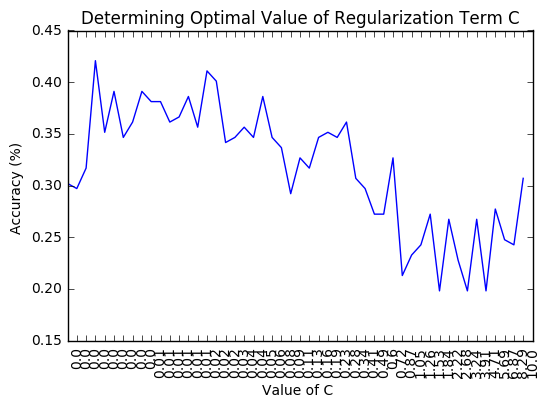

In [55]:
li = [np.arange(1,51)]
plt.plot(cost_accuracies)
plt.title("Determining Optimal Value of Regularization Term C")
plt.xlabel('Value of C ')
plt.ylabel('Accuracy (%) ')
costs_plot = np.around(costs,decimals=2)
plt.xticks(li[0],costs_plot, rotation=90)
plt.figure()

In [56]:
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,test_size = 0.2)

print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


## Varying Eta, Iterations, 

In [57]:
# run logistic regression and vary some parameters
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants

#optimizations = ["BFGSBinaryLogisticRegression","StochasticLogisticRegression","LineSearchLogisticRegression"]
optimizations = ["BFGSBinaryLogisticRegression"]
etas = [0.1, 0.1, 0.001]
iters = [10, 5000, 150]

lr_clf = MultiClassLogisticRegression(eta=eta,iterations=iter_, C=0.02, optimization=optimization,reg=0) # get object


# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = (X[train_indices])
    y_train = y[train_indices]

#     print(X_train)
#     print(y_train)

    X_test = (X[test_indices])
    y_test = y[test_indices]

#         st = time.time()

    lr_clf.fit(X_train,y_train)  # train object
#         t = (time.time() -st)
#         lr_clf_times.append(t)

    lr_clf.fit(X_train,y_train)

    # train the reusable logisitc regression model on the training data
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat+1)
#         lr_clf_accuracies.append(acc)
#         cost_accuracies.append([acc])

    conf = mt.confusion_matrix(y_test,y_hat+1)
    print("====Iteration",iter_num," ====")
    print('For ',optimization,' Accuracy of: ',acc)

    #print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1


====Iteration 0  ====
For  LineSearchLogisticRegression  Accuracy of:  0.267326732673
confusion matrix
 [[ 0  0 19  8  2]
 [ 0  1 19  3  3]
 [ 0  0 27 15 10]
 [ 0  0 24  7 15]
 [ 0  0 21  9 19]]
====Iteration 1  ====
For  LineSearchLogisticRegression  Accuracy of:  0.267326732673
confusion matrix
 [[ 0  8  0 15  1]
 [ 0  8  0 22  1]
 [ 0 15  0 31 11]
 [ 0  8  0 26 14]
 [ 0  4  0 18 20]]
====Iteration 2  ====
For  LineSearchLogisticRegression  Accuracy of:  0.262376237624
confusion matrix
 [[ 0  4  1 30  0]
 [ 0  5  1 30  1]
 [ 0  3  2 33  2]
 [ 0  1  0 41  4]
 [ 0  1  0 38  5]]


## Comparing our Best Logistic Regression Optimization Procedure to that of Scikit-Learn

In [58]:
# run logistic regression and vary some parameters
from sklearn import metrics as mt
from sklearn.linear_model import LogisticRegression as SKLogisticRegression
# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants


lr_sk = SKLogisticRegression(solver='lbfgs',class_weight='balanced',max_iter=500,C=0.002) 

lr_sk_accuracies = []
lr_sk_times = []
lr_sk_mem = []
# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
#     print(X_train)
#     print(y_train)
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    st = time.time()
    mem = memory_usage((lr_sk.fit,(X_train,y_train)))
    #lr_sk.fit(X_train,y_train)
    t = (time.time() -st)
    lr_sk_times.append(t)
    lr_sk_mem.append(mem[0])
    #print(np.hstack((lr_sk.intercept_[:,np.newaxis],lr_sk.coef_)))
    yhat = lr_sk.predict(X_test)
 
    print("Iterations ",lr_sk.n_iter_)
    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    lr_sk_accuracies.append(acc)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1

print(lr_sk_times)
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

Iterations  [139  47 155  62  45]
====Iteration 0  ====
accuracy 0.252475247525
confusion matrix
 [[ 2  0 31  2  0]
 [ 1  1 23  2  0]
 [ 2  1 45  3  0]
 [ 5  1 35  3  0]
 [ 4  1 38  2  0]]
Iterations  [144  59  35  22 217]
====Iteration 1  ====
accuracy 0.232673267327
confusion matrix
 [[ 2  0 28  1  0]
 [ 1  1 32  2  0]
 [ 6  0 39  4  0]
 [ 3  3 40  5  0]
 [ 2  0 33  0  0]]
Iterations  [ 91  37 104  60  45]
====Iteration 2  ====
accuracy 0.207920792079
confusion matrix
 [[ 1  0 26  1  0]
 [ 3  0 37  3  0]
 [ 5  0 38  2  0]
 [ 2  4 34  3  0]
 [ 3  0 37  3  0]]
[0.29910898208618164, 0.26648902893066406, 0.24217700958251953]


32.715702056884766


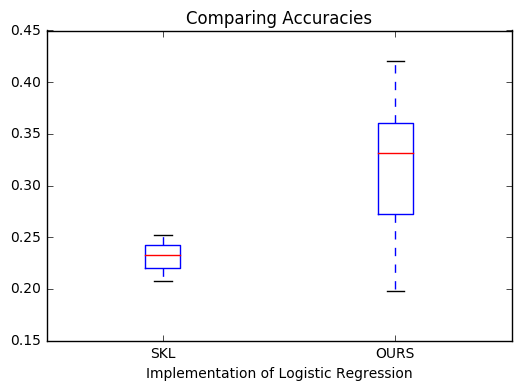

In [59]:
plt.boxplot([lr_sk_accuracies,lr_clf_accuracies])
plt.title("Comparing Accuracies")
plt.xlabel('Implementation of Logistic Regression')
plt.xticks([1,2],['SKL','OURS'])
plt.figure()
print((time.time() -st)*100)
# ax = fig.add_subplot(111)


In [60]:
print(lr_sk_times)
print(lr_clf_times)

[0.29910898208618164, 0.26648902893066406, 0.24217700958251953]
[0.380155086517334, 0.4269559383392334, 0.46659398078918457, 0.4029569625854492, 0.5016298294067383, 0.37512707710266113, 0.3928558826446533, 0.3975670337677002, 0.38536596298217773, 0.42215514183044434, 0.5035450458526611, 0.35132884979248047, 0.4693629741668701, 0.5959179401397705, 0.510523796081543, 0.5050017833709717, 0.4496300220489502, 0.4893341064453125, 0.42505311965942383, 0.38673996925354004, 0.5707991123199463, 0.37647414207458496, 0.4195728302001953, 0.2853410243988037, 0.44449496269226074, 0.47299885749816895, 0.4273550510406494, 0.4198939800262451, 0.5524299144744873, 0.3670790195465088, 0.37652015686035156, 0.4275181293487549, 0.4282529354095459, 0.5057270526885986, 0.33865904808044434, 0.37982797622680664, 0.34958314895629883, 0.34804201126098633, 0.33032798767089844, 0.39108800888061523, 0.27179408073425293, 0.236191987991333, 0.3078899383544922, 0.2901580333709717, 0.36416101455688477, 0.2894139289855957,

In [61]:
print(lr_clf_times)

[0.380155086517334, 0.4269559383392334, 0.46659398078918457, 0.4029569625854492, 0.5016298294067383, 0.37512707710266113, 0.3928558826446533, 0.3975670337677002, 0.38536596298217773, 0.42215514183044434, 0.5035450458526611, 0.35132884979248047, 0.4693629741668701, 0.5959179401397705, 0.510523796081543, 0.5050017833709717, 0.4496300220489502, 0.4893341064453125, 0.42505311965942383, 0.38673996925354004, 0.5707991123199463, 0.37647414207458496, 0.4195728302001953, 0.2853410243988037, 0.44449496269226074, 0.47299885749816895, 0.4273550510406494, 0.4198939800262451, 0.5524299144744873, 0.3670790195465088, 0.37652015686035156, 0.4275181293487549, 0.4282529354095459, 0.5057270526885986, 0.33865904808044434, 0.37982797622680664, 0.34958314895629883, 0.34804201126098633, 0.33032798767089844, 0.39108800888061523, 0.27179408073425293, 0.236191987991333, 0.3078899383544922, 0.2901580333709717, 0.36416101455688477, 0.2894139289855957, 0.3085930347442627, 0.33925700187683105, 0.42737483978271484, 0

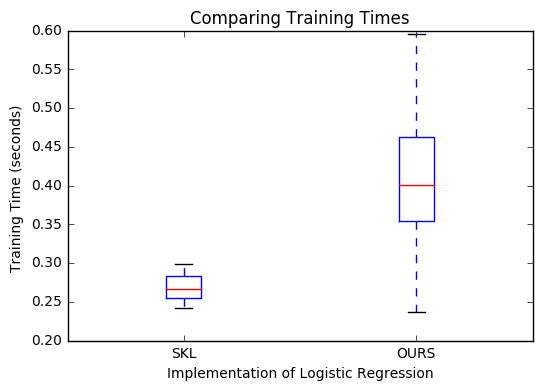

In [62]:
plt.boxplot([lr_sk_times,lr_clf_times])
plt.title("Comparing Training Times")
plt.xlabel('Implementation of Logistic Regression')
plt.ylabel('Training Time (seconds) ')
plt.xticks([1,2],['SKL','OURS'])
plt.figure()

In [63]:
print(lr_sk_mem[0])

150.109375


ValueError: setting an array element with a sequence.

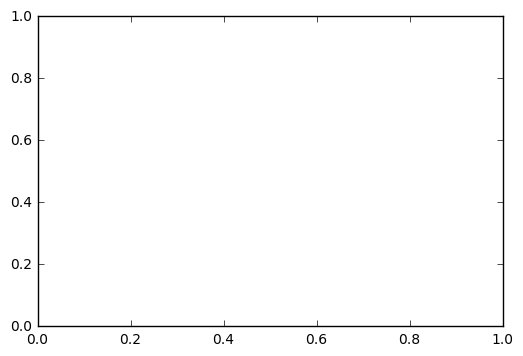

In [64]:
plt.boxplot([lr_sk_mem[0],lr_clf_mem])
plt.title("Comparing Memory ")
plt.xlabel('Implementation of Logistic Regression')
plt.ylabel('Memory Usage (mb) ')
plt.xticks([1,2],['SKL','OURS'])
plt.figure()

## Analyzing which implementation of Logistic Regression would be best for our case

## Exceptional Work

One idea: Make your implementation of logistic regression compatible with the GridSearchCV function that is part of scikit-learn.


In [ ]:
param_grid_input = {'C': costs[:3] }
mglr = MultiClassLogisticRegression(eta=eta,iterations=iter_, C=0.02, optimization="BFGSBinaryLogisticRegression")
gscv = GridSearchCV(cv= cv_object, estimator=mglr, param_grid= param_grid_input, scoring= "accuracy",refit=False)
gscv.fit(X,y)
print(gscv.best_params_)